# **Phase 2:** Multi-Layer Perceptron + ECFP
---
In this notebook, we will test our "middle tier" model, which has the same ECFP strcutre as Phase 1 and same MLP strucutre as Phase 2 (1 FC Layer + 1 Output neuron + 1 Sigmoid function)

**Datasets**
- Clean-Balanced - Cleaned for small molcules and undersampled class 0
- Clean-Unbalanced - Cleaned for small molcules but 11-89 split.
- Dirty-Balanced - Original dataset but undersampled for class 0
- Dirty-Unbalanced - Original dataset with no undersampling

**Evalution**
- 5-Fold Cross Validation - Random state of 42 to ensure same split as previous Phase. 5-Fold CV ensures split of training data was not reason for metric variation
- Leave-One-Drug-Out Validation - Determine set of unique drugs -> choose 5 at random -> iterate 5 times, splitting dataset if drug in column A or column B was the chosen drug.
- Metrics - For 5-Fold CV, metrics were calculated on validation set for each fold and averaged across all folds. For LODO CV, metrics were calculated on teh set of data with the drug not in the training set and averaged across all folds. For the original metrics, metrics were simply calculated on the compoletely separate test set after training on all available data.

**NOTE:** This code was designed to run on an A100-High RAM environment with 12 CPU cores. If that is not the case, please modify/edit so that it doesn't error out.

# Imports and Installs

## Installs

In [ ]:
# Installs
!pip install pytorch-lightning -q
!pip install rdkit==2022.3.4 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 64.9 MB/s eta 0:00:00


## Imports

In [ ]:
# Imports
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Mount Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Clean Train and Test Data

In [ ]:
# Load data for clean vs. unclean datasets
import pandas as pd
f_path = '/content/drive/MyDrive/BME 590 Final Project/Data/'

# Load clean train data
clean_train = pd.read_csv(f_path + 'clean_train_ddi.csv')
clean_train = clean_train.iloc[:, [3, 5, 6]]

# Rename columns
clean_train.columns = ['A', 'B', 'y']

# Display df
clean_train.head()

,A,B,y
0,CC12CCC3C(C1CCC2(C#C)O)CCC4=CC5=C(CC34C)C=NO5,CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3...,0
1,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,C(N)(N)(Cl)Cl,0
2,[O-]S(=O)(=O)[O-],CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0
3,CC(=O)NC(CS)C(=O)O,C1=CC(=CC=C1COC(CN2C=CN=C2)C3=C(C=C(C=C3)Cl)Cl)Cl,0
4,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC#CCC(C)C(C=CC1C(CC2C1CC(=CCCCC(=O)O)C2)O)O,0


In [ ]:
# Load clean test data
clean_test = pd.read_csv(f_path + 'clean_test_ddi.csv')
clean_test = clean_test.iloc[:, [3, 5, 6]]

# Rename columns
clean_test.columns = ['A', 'B', 'y']

# Display df
clean_test.head()

,A,B,y
0,C1CC(N(C1)C(=O)C(CCCCN)NC(CCC2=CC=CC=C2)C(=O)O...,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1
1,CC1=CC=C(C=C1)C2=C(N3C=C(C=CC3=N2)C)CC(=O)N(C)C,CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)...,0
2,CC(C)(C)C#CC=CCN(C)CC1=CC=CC2=CC=CC=C21,CC(C)NCC(COC1=CC=CC2=C1C=CN2)O,0
3,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O,C1CCN(CC1)C2=NC(=NC3=C2N=C(N=C3N4CCCCC4)N(CCO)...,0
4,C1=NC(=NN1C2C(C(C(O2)CO)O)O)C(=O)N,C1CC(=O)NC2=C1C=CC(=C2)OCCCCN3CCN(CC3)C4=C(C(=...,0


## Load Dirty Train and Test Data

In [ ]:
# Load dirty train data
dirty_train = pd.read_csv(f_path + 'dirty_train_ddi.csv')
dirty_train = dirty_train.iloc[:, [3, 5, 6]]

# Rename columns
dirty_train.columns = ['A', 'B', 'y']

# Display df
dirty_train.head()

,A,B,y
0,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(=O)CC4,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,0
1,COC1=CC(=C(C=C1)OC)C(CNC(=O)CN)O,CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C,0
2,CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=CC...,CC1=C(SC=N1)C=CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4...,0
3,CN(CC(CO)O)C(=O)C1=C(C(=C(C(=C1I)C(=O)NCC(CO)O...,CN1CC(=O)N2C(C1=O)CC3=C(C2C4=CC5=C(C=C4)OCO5)N...,0
4,CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4...,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0


In [ ]:
# Load dirty test data
dirty_test = pd.read_csv(f_path + 'dirty_test_ddi.csv')
dirty_test = dirty_test.iloc[:, [3, 5, 6]]

# Rename columns
dirty_test.columns = ['A', 'B', 'y']

# Display df
dirty_test.head()

,A,B,y
0,CCOC(=O)C(CCC1=CC=CC=C1)NC(C)C(=O)N2C3CCCC3CC2...,CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C,0
1,COC1=C(C(=NC=C1)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC(...,CCCCCN=C(N)NNC=C1C=NC2=C1C=C(C=C2)CO,0
2,CN1C2=C(C(=O)N(C1=O)C)NC=N2,C1CC2=C(C=CC(=C2)Cl)C(=C3CCNCC3)C4=C1C=CC=N4,0
3,CCC(=O)OC(C(C)C)OP(=O)(CCCCC1=CC=CC=C1)CC(=O)N...,C1CN2CCC1C(C2)OC(=O)N3CCC4=CC=CC=C4C3C5=CC=CC=C5,0
4,CN=C1CN(C(=C2C=C(C=CC2=N1)Cl)C3=CC=CC=C3)O,C1C(=NC(=O)N1N=CC2=CC=C(O2)C3=CC=C(C=C3)[N+](=...,0


# DataModule and Architecture

## DataModule

In [ ]:
# Data Processing Module for Morgan Fingerprints + concatenation
class DrugInteractionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, radius, nBits, batch_size = 512):
        super().__init__() # Call super-class params
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.radius = radius
        self.nBits = nBits
        self.batch_size = batch_size

    def setup(self, stage = None):

        # Compute Morgan fingerprints for the training set
        self.train_dataset = self.create_dataset(self.train_df)

        # Compute Morgan fingerprints for the validation set
        self.val_dataset = self.create_dataset(self.val_df)

        # Compute Morgan fingerprints for the test set
        self.test_dataset = self.create_dataset(self.test_df)

    # Define method to compute ECFPs
    def create_dataset(self, df):

        # Return list
        fps = []

        # Iterate
        for _, row in df.iterrows():

            # Extract Molecules from SMILES
            molA = Chem.MolFromSmiles(row['A'])
            molB = Chem.MolFromSmiles(row['B'])

            # Convert to ECFP
            fpA = AllChem.GetMorganFingerprintAsBitVect(molA, self.radius, nBits = self.nBits, useChirality = True)
            fpB = AllChem.GetMorganFingerprintAsBitVect(molB, self.radius, nBits = self.nBits, useChirality = True)

            # Concatenate and append
            concatenated_fp = np.hstack((fpA, fpB))
            fps.append(concatenated_fp)

        # Extract y labels
        labels = torch.tensor(df['y'].values)

        # Convert to tensor
        fps_tensor = torch.tensor(np.array(fps), dtype = torch.float32)
        return TensorDataset(fps_tensor, labels)

    # Create training dataloader
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers = 11, shuffle = True)

    # Create validation dataloader [Note: Change batch_size to len(self.val_df) if using leave-one-drug-out to avoid univariate class issues during evaluation]
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = len(self.val_df), num_workers = 11, shuffle = False)

    # Create test dataloader
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers = 11, shuffle = False)

## Model

In [ ]:
# Define the model
class DrugInteractionModel(pl.LightningModule):
    def __init__(self, input_size):
        # Call super-class init
        super(DrugInteractionModel, self).__init__()

        # Define loss functiopn
        self.criterion = nn.BCELoss()

        # MLP layers [Same as Phase 3 model]
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()  # Outputs probability between 0 and 1 of being classified as interacting (class 1)
        )

    # Feed forward method
    def forward(self, fingerprints):
        # Pass the concatenated fingerprint through the MLP
        output = self.classifier(fingerprints)
        return output

    # Calculate custom metrics
    def compute_metrics(self, outputs, labels):
        preds = torch.round(outputs.detach())  # Detach and binarize predictions
        labels = labels.detach()

        # Convert to CPU and NumPy
        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()

        # Calculate relevant metrics
        accuracy = accuracy_score(labels_np, preds_np)
        precision = precision_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 precision
        recall = recall_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 recall
        f1 = f1_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 f1 score
        balanced_acc = balanced_accuracy_score(labels_np, preds_np)
        auroc = roc_auc_score(labels_np, outputs.detach().cpu().numpy())  # For AUROC, use the raw outputs

        return accuracy, precision, recall, f1, balanced_acc, auroc

    # Define training step
    def training_step(self, batch, batch_idx):

        # Load batch
        fingerprints, labels = batch

        # Compute classes
        outputs = self(fingerprints)

        # Determine loss
        loss = self.criterion(outputs, labels.unsqueeze(1).float())

        return loss

    # Log metrics on validation step
    def validation_step(self, batch, batch_idx):
        fingerprints, labels = batch
        outputs = self(fingerprints)
        loss = nn.BCELoss()(outputs, labels.unsqueeze(1).float())
        accuracy, precision, recall, f1, balanced_acc, auroc = self.compute_metrics(outputs, labels)
        self.log('val_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_acc', accuracy, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_auroc', auroc, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_balanced_acc', balanced_acc, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_precision', precision, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_recall', recall, on_step = True, on_epoch = True, prog_bar = True)
        self.log('val_f1', f1, on_step = True, on_epoch = True, prog_bar = True)

    # Log metrics on test step
    def test_step(self, batch, batch_idx):
        fingerprints, labels = batch
        outputs = self(fingerprints)
        loss = nn.BCELoss()(outputs, labels.unsqueeze(1).float())
        accuracy, precision, recall, f1, balanced_acc, auroc = self.compute_metrics(outputs, labels)
        self.log('test_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_acc', accuracy, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_auroc', auroc, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_balanced_acc', balanced_acc, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_precision', precision, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_recall', recall, on_step = True, on_epoch = True, prog_bar = True)
        self.log('test_f1', f1, on_step = True, on_epoch = True, prog_bar = True)

    # Use Adam Optimizer (Try AdamW in future)
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.001)

# Evaluation

## Base Evaluation Method

In [ ]:
def train_and_evaluate(dataset, test_dataset, balance_data = True, max_epochs = 10):

    # Split dataset into training and validation
    train, val = train_test_split(dataset, test_size = 0.2, random_state = 42, shuffle = True)

    # Apply undersampling if balance_data is True
    if balance_data:
        undersampler = RandomUnderSampler(sampling_strategy = 'majority')
        X_train = train.drop(columns = ['y'])
        y_train = train['y']
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        train = pd.concat([X_train, y_train], axis = 1)

    # Initialize DataModule and Model
    data_module = DrugInteractionDataModule(train, val, test_dataset, radius = 2, nBits = 1024, batch_size = 512)
    model = DrugInteractionModel(input_size = 2048)

    # Train the model
    trainer = pl.Trainer(max_epochs = max_epochs)
    trainer.fit(model, data_module)

    # Evaluate the model on the test set
    trainer.test(model, datamodule = data_module)

    # Extract and return metrics
    metrics = trainer.logged_metrics

    return metrics

In [ ]:
# Run the function on the clean and dirty datasets and extract a dictionary of final metrics for each
clean_metrics_balanced = train_and_evaluate(clean_train, clean_test, balance_data = True)
clean_metrics_unbalanced = train_and_evaluate(clean_train, clean_test, balance_data = False)
dirty_metrics_balanced = train_and_evaluate(dirty_train, dirty_test, balance_data = True)
dirty_metrics_unbalanced = train_and_evaluate(dirty_train, dirty_test, balance_data = False)

In [ ]:
# This reformats and extracts the tensor values as floats to plot results
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        if torch.is_tensor(value):
            formatted_dict[key] = value.item()

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['test_balanced_acc_epoch', 'test_f1_epoch', 'test_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to be encoded for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rename data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'test_balanced_acc_epoch': 'Balanced Accuracy',
    'test_f1_epoch': 'F1 Score',
    'test_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Value')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure to local environment
fig.savefig('MLP_Morgan_Performance.png', dpi = 600)

## K-Fold Cross Validation



In [ ]:
# Training method for K-Fold validation
def train_and_evaluate_kfold(dataset, test_dataset, balance_data = True, max_epochs = 10, n_splits = 5):

    # Initialize KFold splitter
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

    # Array to store metrics of each fold
    fold_metrics = []

    # For each fold
    for train_index, val_index in kf.split(dataset):

        # Split the trianing and validation
        train, val = dataset.iloc[train_index], dataset.iloc[val_index]

        # If we need to balance the data
        if balance_data:

            # Initialize undersampler
            undersampler = RandomUnderSampler(sampling_strategy = 'majority')
            X_train = train.drop(columns = ['y'])
            y_train = train['y']
            X_train, y_train = undersampler.fit_resample(X_train, y_train)
            train = pd.concat([X_train, y_train], axis = 1)

        # Initialize DataModule and Model
        data_module = DrugInteractionDataModule(train, val, test_dataset, radius = 2, nBits = 1024, batch_size = 512)
        model = DrugInteractionModel(input_size = 2048)

        # Train model
        trainer = pl.Trainer(max_epochs = max_epochs)
        trainer.fit(model, data_module)

        # Evaluate on the validation set
        val_result = trainer.validate(model, dataloaders = data_module)
        fold_metrics.append(val_result[0])

    # Average metrics across folds
    avg_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0].keys()}
    return avg_metrics

In [ ]:
# Train each model on 5 fold cross-validation, averaging the results across each fold
clean_metrics_balanced_k = train_and_evaluate_kfold(clean_train, clean_test, balance_data = True)
clean_metrics_unbalanced_k = train_and_evaluate_kfold(clean_train, clean_test, balance_data = False)
dirty_metrics_balanced_k = train_and_evaluate_kfold(dirty_train, dirty_test, balance_data = True)
dirty_metrics_unbalanced_k = train_and_evaluate_kfold(dirty_train, dirty_test, balance_data = False)

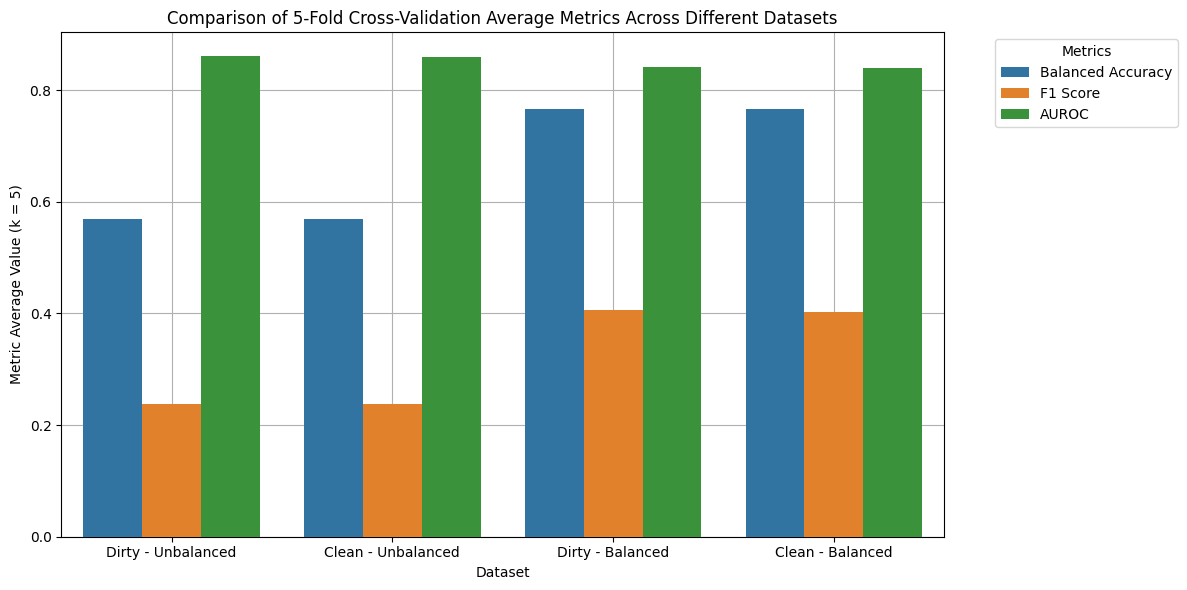

In [ ]:
# Plotting code for k-fold validation

# This reformats and extracts the tensor values as floats
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        formatted_dict[key] = value

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['val_balanced_acc_epoch', 'val_f1_epoch', 'val_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced_k, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced_k, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced_k, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced_k, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rname data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'val_balanced_acc_epoch': 'Balanced Accuracy',
    'val_f1_epoch': 'F1 Score',
    'val_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of 5-Fold Cross-Validation Average Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Average Value (k = 5)')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('MLP_Performance_kfold.png', dpi = 600)

## Leave-One-Out Cross Validation

In [ ]:
# Method for leave-one-out cross validation
def train_and_evaluate_leave_one_drug_out(dataset, test_df, balance_data = True, max_epochs = 10, num_drugs = 5, random_state = 42):

    # Set the random seed for reproducibility
    random.seed(random_state)

    # Combine unique drugs from columns 'A' and 'B'
    unique_drugs_A = set(dataset['A'].unique())
    unique_drugs_B = set(dataset['B'].unique())
    combined_unique_drugs = unique_drugs_A.union(unique_drugs_B)

    # Randomly select five drugs
    selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))

    # Array for each fold
    fold_metrics = []

    # For each drug...
    for drug in selected_drugs:

        # Create a validation set where the drug appears in either 'A' or 'B'
        val = dataset[(dataset['A'] == drug) | (dataset['B'] == drug)]

        # Create a training set excluding those rows
        train = dataset[(dataset['A'] != drug) & (dataset['B'] != drug)]

        # If we need to balance the data
        if balance_data:
            undersampler = RandomUnderSampler(sampling_strategy = 'majority')
            X_train = train.drop(columns = ['y'])
            y_train = train['y']
            X_train, y_train = undersampler.fit_resample(X_train, y_train)
            train = pd.concat([X_train, y_train], axis = 1)

        # Initialize DataModule and Model
        data_module = DrugInteractionDataModule(train, val, test_df, radius = 2, nBits = 1024, batch_size = 512)
        model = DrugInteractionModel(input_size = 2048)

        trainer = pl.Trainer(max_epochs = max_epochs)
        trainer.fit(model, data_module)

        # Evaluate on the validation set
        val_result = trainer.validate(model, dataloaders = data_module)
        fold_metrics.append(val_result[0])

    # Average metrics across folds
    avg_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0].keys()}
    return avg_metrics

In [ ]:
# Train each model on 5 fold cross-validation, averaging the results across each fold
clean_metrics_balanced_k_one_out = train_and_evaluate_leave_one_drug_out(clean_train, clean_test, balance_data = True)

<ipython-input-12-3b7f85ea1f77>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
29606it [00:52, 563.27

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
29606it [00:52, 560.97it/s]
462it [00:00, 637.32it/s]
34048it [01:00, 562.23it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9372294372294372     │
│      val_auroc_epoch      │    0.9934924078091106     │
│  val_balanced_acc_epoch   │    0.9685466377440347     │
│       val_f1_epoch        │    0.06451612903225806    │
│      val_loss_epoch       │    0.29087045788764954    │
│    val_precision_epoch    │    0.03333333333333333    │
│     val_recall_epoch      │            1.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
29544it [00:52, 563.66it/s]
475it [00:00, 580.71it/s]
34048it [01:00, 563.59it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
29544it [00:52, 563.51it/s]
475it [00:00, 599.75it/s]
34048it [01:00, 561.82it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8947368421052632     │
│      val_auroc_epoch      │    0.7387133182844244     │
│  val_balanced_acc_epoch   │    0.5956546275395034     │
│       val_f1_epoch        │    0.24242424242424243    │
│      val_loss_epoch       │    0.3738722503185272     │
│    val_precision_epoch    │    0.23529411764705882    │
│     val_recall_epoch      │           0.25            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
29526it [00:52, 562.87it/s]
466it [00:00, 552.19it/s]
34048it [01:00, 560.80it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
29526it [00:52, 559.28it/s]
466it [00:00, 554.99it/s]
34048it [01:01, 556.48it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7939914163090128     │
│      val_auroc_epoch      │    0.8288091822094692     │
│  val_balanced_acc_epoch   │    0.7548350071736012     │
│       val_f1_epoch        │    0.37662337662337664    │
│      val_loss_epoch       │    0.4634411633014679     │
│    val_precision_epoch    │    0.25663716814159293    │
│     val_recall_epoch      │    0.7073170731707317     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
29446it [00:52, 560.35it/s]
450it [00:00, 642.58it/s]
34048it [01:00, 559.63it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
29446it [00:52, 558.92it/s]
450it [00:00, 634.11it/s]
34048it [01:00, 559.18it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7155555555555555     │
│      val_auroc_epoch      │    0.7065141021780588     │
│  val_balanced_acc_epoch   │    0.6434808792532369     │
│       val_f1_epoch        │    0.40186915887850455    │
│      val_loss_epoch       │    0.5690475106239319     │
│    val_precision_epoch    │    0.3233082706766917     │
│     val_recall_epoch      │    0.5308641975308642     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
29482it [00:52, 560.52it/s]
460it [00:00, 610.12it/s]
34048it [01:00, 560.04it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
29482it [00:52, 558.95it/s]
460it [00:00, 616.72it/s]
34048it [01:00, 560.09it/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7152173913043478     │
│      val_auroc_epoch      │    0.7777377953700372     │
│  val_balanced_acc_epoch   │    0.7281796009755708     │
│       val_f1_epoch        │    0.4177777777777778     │
│      val_loss_epoch       │    0.5641177892684937     │
│    val_precision_epoch    │    0.29012345679012347    │
│     val_recall_epoch      │     0.746031746031746     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
dirty_metrics_balanced_k_one_out = train_and_evaluate_leave_one_drug_out(dirty_train, dirty_test, balance_data = True, random_state = 43)

<ipython-input-16-3b7f85ea1f77>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.5367965367965368     │
│      val_auroc_epoch      │     0.841630351192002     │
│  val_balanced_acc_epoch   │    0.7138682389130993     │
│       val_f1_epoch        │    0.2913907284768212     │
│      val_loss_epoch       │     0.745084822177887     │
│    val_precision_epoch    │    0.17254901960784313    │
│     val_recall_epoch      │    0.9361702127659575     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7643312101910829     │
│      val_auroc_epoch      │    0.6831537152580829     │
│  val_balanced_acc_epoch   │    0.6171866137266023     │
│       val_f1_epoch        │    0.24489795918367346    │
│      val_loss_epoch       │    0.5118668079376221     │
│    val_precision_epoch    │    0.16981132075471697    │
│     val_recall_epoch      │    0.43902439024390244    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.6893617021276596     │
│      val_auroc_epoch      │    0.7752823955669225     │
│  val_balanced_acc_epoch   │     0.702419011082694     │
│       val_f1_epoch        │    0.5034013605442177     │
│      val_loss_epoch       │    0.5782620906829834     │
│    val_precision_epoch    │    0.3854166666666667     │
│     val_recall_epoch      │    0.7254901960784312     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7932489451476793     │
│      val_auroc_epoch      │    0.7218637992831541     │
│  val_balanced_acc_epoch   │    0.7311827956989247     │
│       val_f1_epoch        │    0.10909090909090909    │
│      val_loss_epoch       │    0.49857041239738464    │
│    val_precision_epoch    │    0.0594059405940594     │
│     val_recall_epoch      │    0.6666666666666666     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7677824267782427     │
│      val_auroc_epoch      │    0.8099411292480599     │
│  val_balanced_acc_epoch   │    0.7025689055392026     │
│       val_f1_epoch        │    0.4477611940298507     │
│      val_loss_epoch       │    0.4790697395801544     │
│    val_precision_epoch    │    0.3543307086614173     │
│     val_recall_epoch      │    0.6081081081081081     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
dirty_metrics_unbalanced_k_one_out = train_and_evaluate_leave_one_drug_out(dirty_train, dirty_test, balance_data = False, random_state = 43)

<ipython-input-16-3b7f85ea1f77>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9025974025974026     │
│      val_auroc_epoch      │    0.8738272237887721     │
│  val_balanced_acc_epoch   │    0.6627787746731607     │
│       val_f1_epoch        │    0.4303797468354431     │
│      val_loss_epoch       │    0.29728251695632935    │
│    val_precision_epoch    │          0.53125          │
│     val_recall_epoch      │    0.3617021276595745     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9129511677282378     │
│      val_auroc_epoch      │    0.6893363584798639     │
│  val_balanced_acc_epoch   │            0.5            │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.2818666100502014     │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7978723404255319     │
│      val_auroc_epoch      │    0.8262734441602728     │
│  val_balanced_acc_epoch   │    0.5343137254901961     │
│       val_f1_epoch        │    0.12844036697247707    │
│      val_loss_epoch       │    0.42978745698928833    │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │    0.06862745098039216    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9831223628691983     │
│      val_auroc_epoch      │    0.7125448028673834     │
│  val_balanced_acc_epoch   │    0.5555555555555556     │
│       val_f1_epoch        │    0.19999999999999998    │
│      val_loss_epoch       │    0.13390406966209412    │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │    0.1111111111111111     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8472803347280334     │
│      val_auroc_epoch      │    0.8308134867540808     │
│  val_balanced_acc_epoch   │    0.5067567567567568     │
│       val_f1_epoch        │   0.026666666666666665    │
│      val_loss_epoch       │     0.365764856338501     │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │   0.013513513513513514    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
clean_metrics_unbalanced_k_one_out = train_and_evaluate_leave_one_drug_out(clean_train, clean_test, balance_data = False, random_state = 43)

<ipython-input-30-8fc984267050>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9309623430962343     │
│      val_auroc_epoch      │    0.8358505564387918     │
│  val_balanced_acc_epoch   │    0.5147058823529411     │
│       val_f1_epoch        │    0.05714285714285715    │
│      val_loss_epoch       │    0.20071452856063843    │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │   0.029411764705882353    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9508547008547008     │
│      val_auroc_epoch      │    0.5583253435602429     │
│  val_balanced_acc_epoch   │    0.4977628635346757     │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.20835882425308228    │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8583690987124464     │
│      val_auroc_epoch      │    0.8132196969696969     │
│  val_balanced_acc_epoch   │            0.5            │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.42739614844322205    │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9323770491803278     │
│      val_auroc_epoch      │    0.8275724275724275     │
│  val_balanced_acc_epoch   │            0.5            │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.20460203289985657    │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | criterion  | BCELoss    | 0     
1 | classifier | Sequential | 2.0 K 
------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9737991266375546     │
│      val_auroc_epoch      │    0.7654046028210839     │
│  val_balanced_acc_epoch   │    0.4966592427616926     │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.1623321771621704     │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

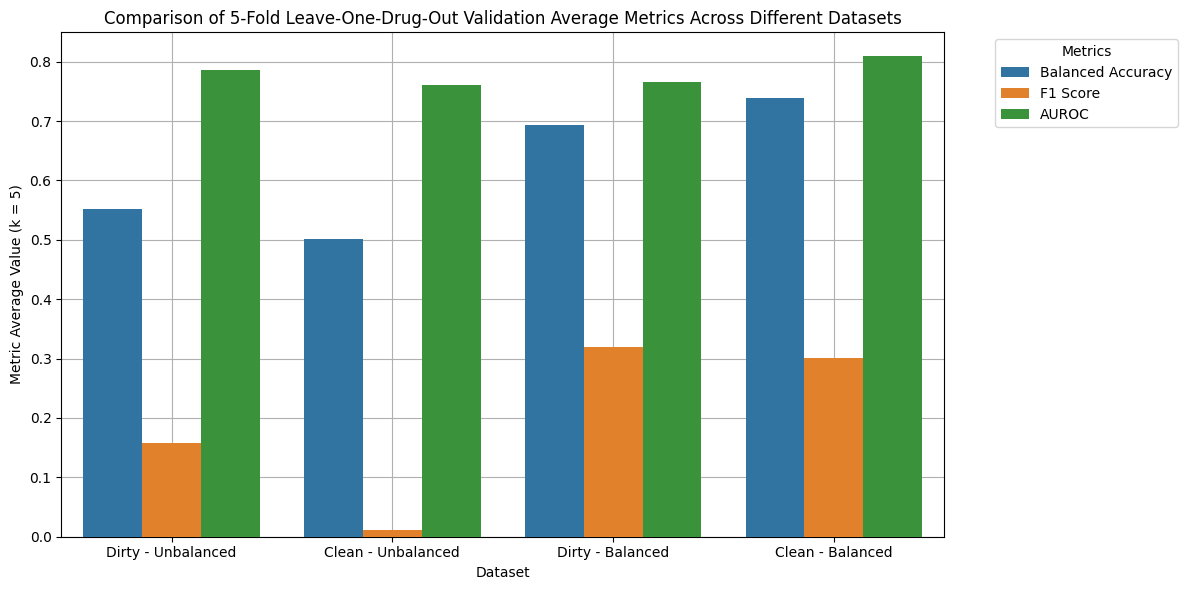

In [ ]:
# Plotting code for k-fold validation
# This reformats and extracts the tensor values as floats
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        formatted_dict[key] = value

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['val_balanced_acc_epoch', 'val_f1_epoch', 'val_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced_k_one_out, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced_k_one_out, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced_k_one_out, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced_k_one_out, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rname data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'val_balanced_acc_epoch': 'Balanced Accuracy',
    'val_f1_epoch': 'F1 Score',
    'val_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of 5-Fold Leave-One-Drug-Out Validation Average Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Average Value (k = 5)')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('mlp_Performance_kfold_one_out.png', dpi = 600)

In [ ]:
# If desired, load tensorboard to visualize all logged metrics (If this doesn't work, use weights and biases or modify code to plot manually)
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

# Discussion

See Phase 3 or Phase 1 for detailed discussion of results. MLP made no significant differnce compared to random forest. Variations in leave-one-out results are due to the specific drug selected.